In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["font.size"] = 16

import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals

In [2]:
Omega_01 = 5.0  # Ghz
Delta = -0.25
Omega_02 = 2 * Omega_01 + Delta
Lambda = 0.8

ket0 = np.array([[1, 0, 0]]).T
ket1 = np.array([[0, 1, 0]]).T
ket2 = np.array([[0, 0, 1]]).T

sigma_m1 = ket0 @ ket1.T.conj()
sigma_m2 = ket1 @ ket2.T.conj()

sigma_p1 = sigma_m1.T.conj()
sigma_p2 = sigma_m2.T.conj()

P0, P1, P2 = ket0 @ ket0.T.conj(), ket1 @ ket1.T.conj(), ket2 @ ket2.T.conj()

In [3]:
# drift, control, R_frame
drift = 2 * np.pi * (Omega_01 * P1 + Omega_02 * P2)
control = [2 * np.pi * (sigma_p1 + sigma_m1 + Lambda * (sigma_p2 + sigma_m2))]
R_frame = 2 * np.pi * (Omega_01 * P1 + 2 * Omega_01 * P2)

In [4]:
y0 = Statevector([1.0, 0.0, 0.0])
dt = 0.1
area = 0.4
sigma = 5  # ns
# amp = area / sigma
sigma = sigma / dt  # ns

duration = np.math.ceil(sigma * 5)
T = duration * dt  # ns

In [5]:
# construct the solver
hamiltonian_solver = Solver(
    static_hamiltonian=drift,
    hamiltonian_operators=control,
    rotating_frame=R_frame,
    rwa_cutoff_freq=1.5 * Omega_01,
    rwa_carrier_freqs=[Omega_01],
)

In [6]:
def make_signal(duration, amp, sigma, w, waveform, dt=dt):

    with pulse.build(name="spec") as spec:
        if waveform == "g":
            pulse.play(
                pulse.Gaussian(duration=duration, amp=amp, sigma=sigma),
                pulse.DriveChannel(0),
            )
        elif waveform == "d":
            pulse.play(
                pulse.Drag(duration=duration, amp=amp, sigma=sigma, beta=2.0),
                pulse.DriveChannel(0),
            )

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signals = converter.get_signals(spec)
    return signals  # , spec.draw()

In [7]:
def solve(duration, amp, sigma, omega_d, waveform, dt=dt):
    solutions = hamiltonian_solver.solve(
        t_span=[0.0, T],
        y0=y0,
        t_eval=np.linspace(0, T, 101),
        signals=[make_signal(duration, amplitudes, sigma, omega_d, waveform, dt) for amplitudes in amp],
    )
    return solutions

In [8]:
amp_range = np.linspace(-0.15,0.15,200) #np.linspace(0.03825,0.04675,50)

%time solutions_g = solve(duration, amp_range, sigma, Omega_01, 'g')
max_amp_g = np.array([sol.y[-1].probabilities() for sol in solutions_g])

# %time solutions_d = solve(duration, amp_range, sigma, Omega_01, 'd')
# max_amp_d = np.array([sol.y[-1].probabilities() for sol in solutions_d])

CPU times: user 4min 44s, sys: 0 ns, total: 4min 44s
Wall time: 4min 43s


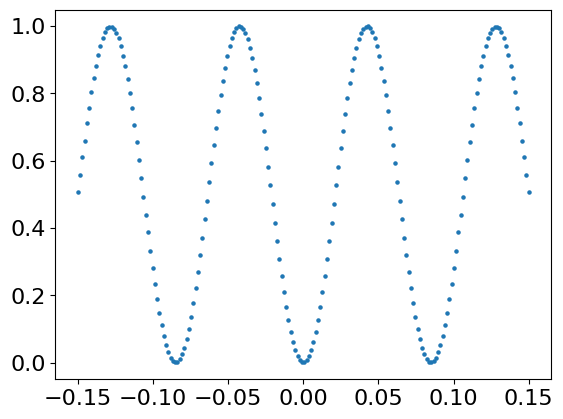

In [9]:
plt.scatter(amp_range, max_amp_g[:,1], s=5)

In [10]:
from scipy.optimize import curve_fit

fit_func = (
    lambda x, A, B, rabi_rate, phi: A * np.cos(2 * np.pi * x / rabi_rate - phi) + B
)

popt, _ = curve_fit(
    fit_func,
    amp_range,
    max_amp_g[:, 1],
    p0=[1, 0.5, 0.1, 0.1],
)
print(popt)

[-5.00527971e-01  5.01518178e-01  8.53097526e-02  1.33151923e-07]


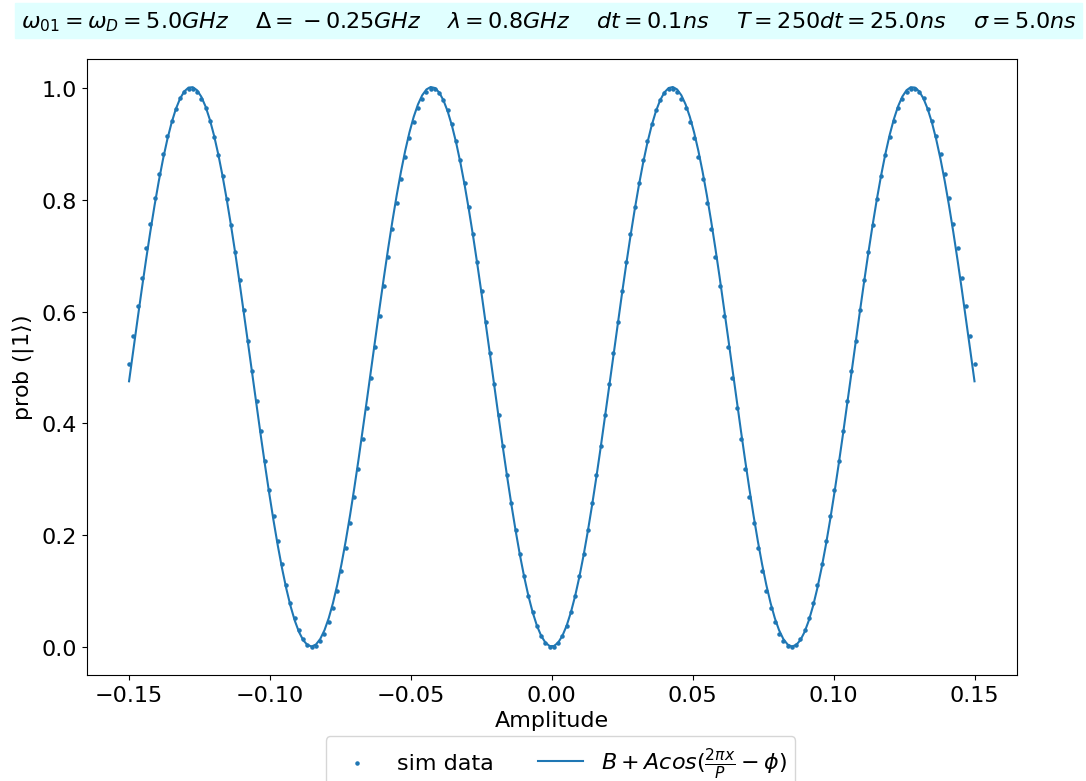

In [11]:
fig = plt.figure(figsize = (12,8))
plt.scatter(amp_range, max_amp_g[:,1], s=5, label="sim data")
plt.plot(amp_range, fit_func(amp_range, *popt), label=r"$B + A cos(\frac{2\pi x}{P} - \phi)$")
plt.xlabel("Amplitude")
plt.ylabel(r"prob $(|1\rangle)$")
fig.legend(ncol=2,loc=(0.3, -0.01))
fig.text(
    0.51,
    0.92,
    (
        f"$\omega_{{01}} = \omega_D = {Omega_01} GHz$    "
        + f"$\Delta = {Delta} GHz$    "
        + f"$\lambda = {Lambda} GHz$    "
        + f"$dt = {dt} ns$    "
        + f"$T = {duration}dt = {T} ns$    "
        + f"$\sigma = {sigma * dt} ns$"
    ),
    backgroundcolor="lightcyan",
    fontsize=16,
    horizontalalignment="center",
);
plt.savefig("rabi.pdf")

In [12]:
optimal_X_amp = popt[2]/2
print(optimal_X_amp)

0.04265487629619379
